# Feature selection

In [1]:
%load_ext autoreload
%autoreload 2

In [30]:
import missingno as msno
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ptbxl.utils.paths import data_processed_dir

sns.set_theme()


## Load data

In [25]:
# Leads names
leads = ['I', 'II', 'III', 'aVF', 'aVR', 'aVL', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
feature_columns = ['DF_' + lead for lead in leads]

In [21]:
dataset = pd.read_csv(data_processed_dir('dominant_freq_dataset.csv'))
dataset = dataset.set_index('ecg_id')
dataset = dataset.drop(['patient_id'], axis=1)

print(f'Number of samples: {len(dataset)}')
display(dataset.head())

Number of samples: 9553


,age,sex,height,weight,nurse,site,device,recording_date,report,scp_codes,...,DF_III,DF_aVF,DF_aVR,DF_aVL,DF_V1,DF_V2,DF_V3,DF_V4,DF_V5,DF_V6
ecg_id,,,,,,,,,,,,,,,,,,,,,
17,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-01-20 14:25:25,vorhof:hf 280 tachykardes vorhofflimmern uebe...,"{'AFLT': 100.0, 'ABQRS': 0.0, 'AFIB': 0.0}",...,2.375,2.375,2.375,0.125,2.375,2.375,2.375,2.375,2.375,2.375
18,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-01-20 15:17:24,"vorhofflattern 2:1 Überleitung,jetzt nach isop...",{'AFLT': 100.0},...,0.125,2.125,2.125,0.125,2.125,2.125,2.125,2.125,2.125,2.125
20,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-01-23 12:55:32,supraventrikulÄre ersatzsystole(n) interponier...,"{'AFLT': 100.0, 'ABQRS': 0.0}",...,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375,2.375
23,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-01-25 12:49:40,"2:1 Überleitung bei vorhofflattern,jetzt unter...",{'AFLT': 100.0},...,2.125,2.125,2.125,4.250,2.125,2.125,2.125,2.125,2.125,2.125
34,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-02-10 12:04:03,"erneut vorhofflattern unter 3x1 cordichin ,1x0...",{'AFLT': 100.0},...,0.250,2.250,2.250,0.250,2.250,2.250,2.250,2.250,2.250,2.250


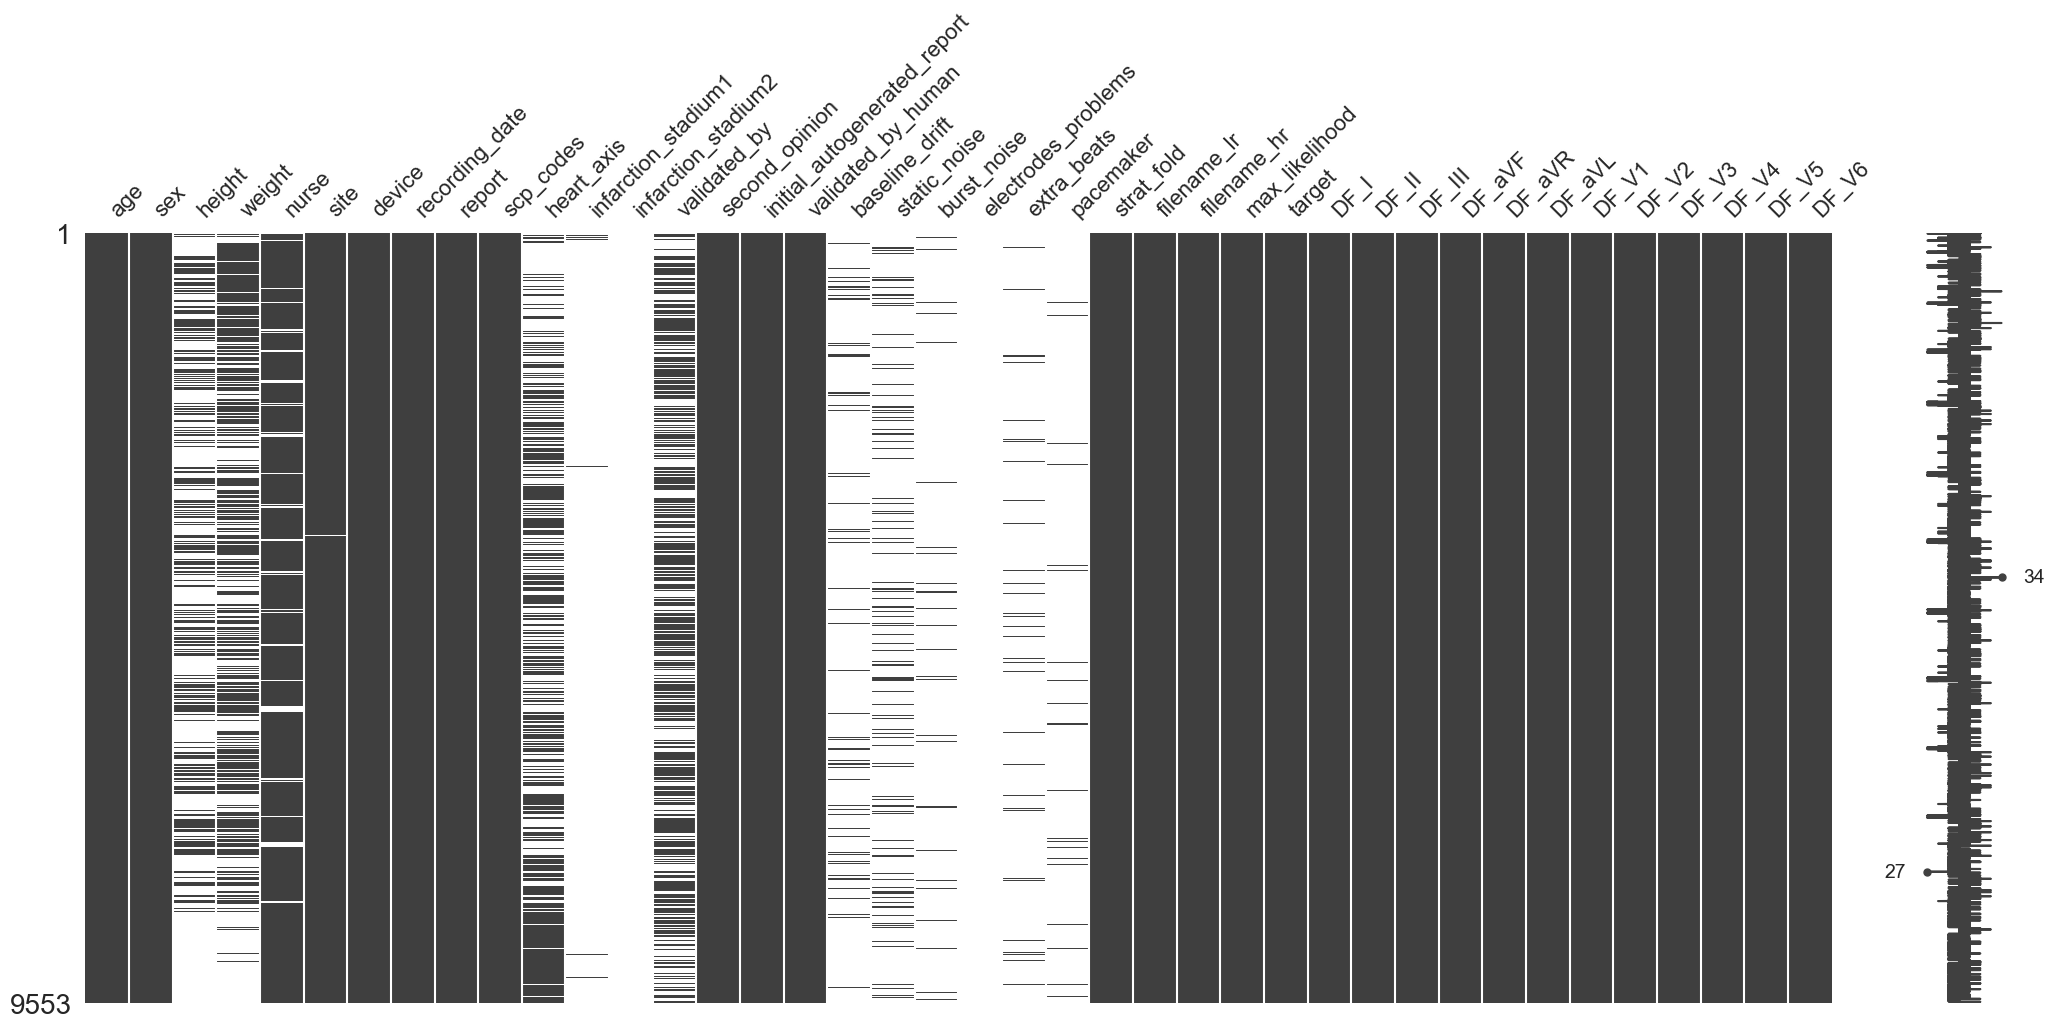

In [31]:
msno.matrix(dataset)
plt.show()

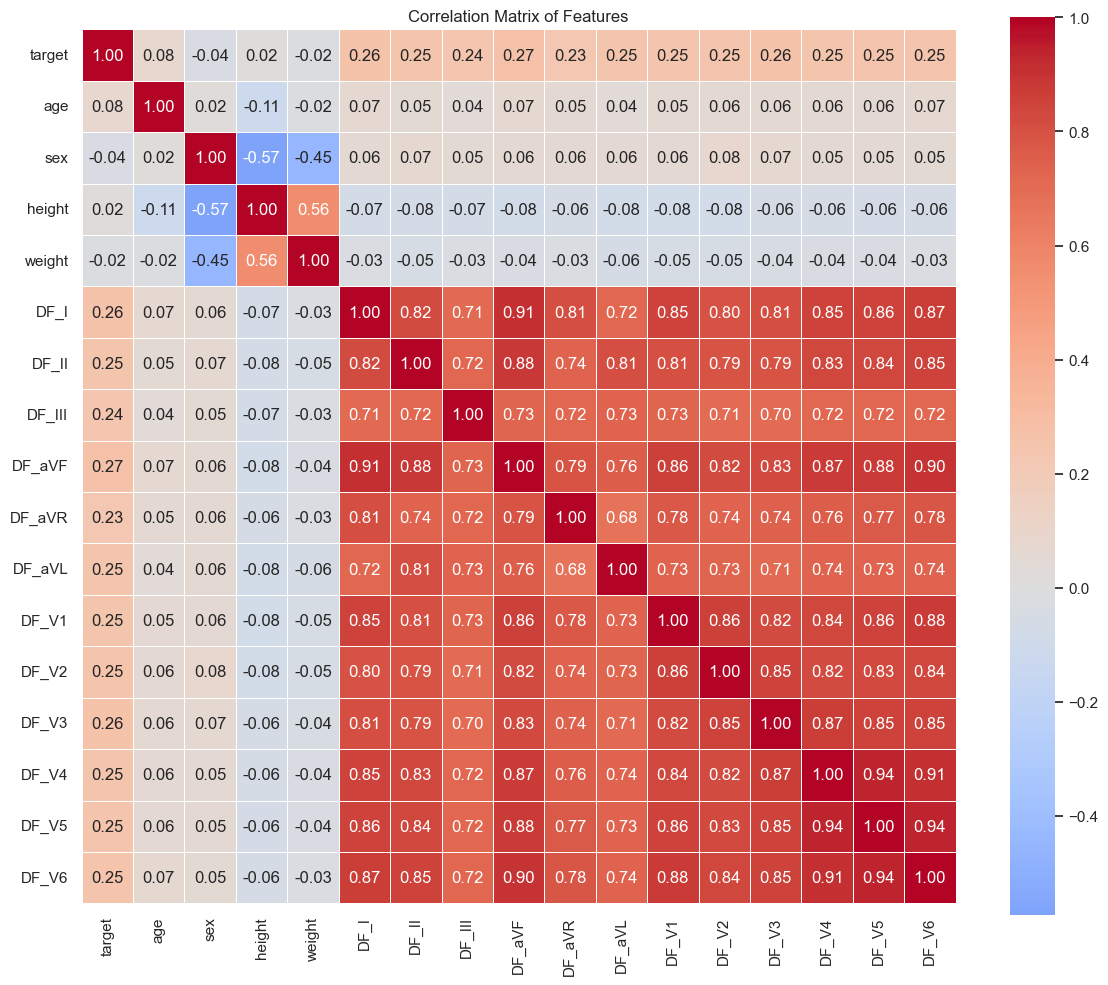

In [32]:
# Calculate correlation matrix
correlation_matrix = dataset[['target', 'age', 'sex', 'height', 'weight'] + feature_columns].corr()

# Create a larger figure
plt.figure(figsize=(12, 10))

# Create heatmap with seaborn
sns.heatmap(correlation_matrix, 
            annot=True,  # Show correlation values
            cmap='coolwarm',  # Color scheme
            center=0,  # Center the colormap at 0
            square=True,  # Make cells square
            fmt='.2f',  # Format correlation values to 2 decimal places
            linewidths=0.5)  # Add grid lines

plt.title('Correlation Matrix of Features')
plt.tight_layout()
plt.show()